<a href="https://colab.research.google.com/github/soumick1/Neural_Style_Transfer/blob/main/Pytorch_Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
imsize = 512 if torch.cuda.is_available() else 256
#scale imported image
#transform it into torch tensor
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

In [ ]:
#Helper function
def image_loader(image_name):
  image = Image.open(image_name)
  print(image.size)
  image = image.resize((750, 561))
  print(image.size)
  #fake batch dimension reqd to fit network's input dimension
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)


In [ ]:
!gdown 'https://mymodernmet.com/wp/wp-content/uploads/2019/06/monet-impression-sunrise-2.jpg'

Downloading...
From: https://mymodernmet.com/wp/wp-content/uploads/2019/06/monet-impression-sunrise-2.jpg
To: /content/monet-impression-sunrise-2.jpg
100% 134k/134k [00:00<00:00, 8.55MB/s]


In [ ]:
!gdown 'https://youthincmag.com/wp-content/uploads/2017/04/robert.jpg'

Downloading...
From: https://youthincmag.com/wp-content/uploads/2017/04/robert.jpg
To: /content/robert.jpg
100% 44.4k/44.4k [00:00<00:00, 6.55MB/s]


In [ ]:
image_directory = '/content/'
style_img = image_loader(image_directory + 'monet-impression-sunrise-2.jpg')
content_img = image_loader(image_directory + 'robert.jpg')


(750, 561)
(750, 561)
(770, 473)
(750, 561)


In [ ]:
print(style_img.size()) 
print(content_img.size())

torch.Size([1, 3, 512, 684])
torch.Size([1, 3, 512, 684])


In [ ]:
assert style_img.size() == content_img.size()

In [ ]:
unloader = transforms.ToPILImage() #reconvert from tensor to pillow image

In [ ]:
plt.ion()

In [ ]:
def imshow(tensor, title=None):
  image = tensor.cpu().clone() #we clone the tensor to not do any changes to it
  image = image.squeeze(0) # we remove the fake batches
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

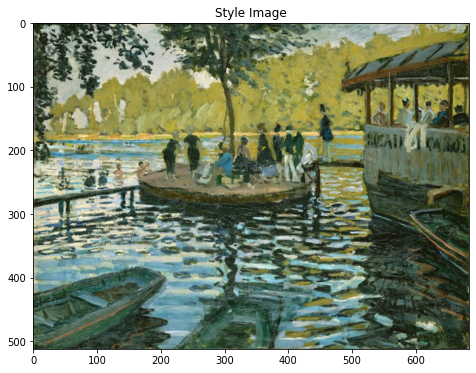

In [ ]:
plt.figure(figsize=(8,6))
imshow(style_img, title='Style Image')

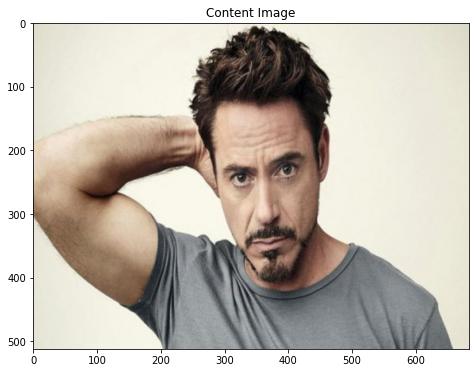

In [ ]:
plt.figure(figsize=(8,6))
imshow(content_img, title='Content Image')

In [ ]:
class ContentLoss(nn.Module):

  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    #we detach the target content from the tree used
    #to dynamically compute the gradient his is the stated value,
    #not a variable. Otherwise the forward method of the criterion will show an error
    self.target = target.detach()

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input

In [ ]:
#Now for styleLoss
def gram_matrix(input):
  a,b,c,d = input.size()
  #a = batch size (=1)
  #b = no. of feature maps
  #(c,d) dimensions of a f. map (N = c*d)

  features = input.view(a*b, c*d) #resize F_XL into \hat F_XL

  G = torch.mm(features, features.t()) #compute the gram product

  #we 'normalize' the gram matrix by dividing the no. of element in each feature map
  return G.div(a*b*c*d)


class StyleLoss(nn.Module):

  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach()

  def forward(self, input):
    G = gram_matrix(input)
    self.loss = F.mse_loss(G, self.target)
    return input


In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
#normalized by special values from the research paper

In [ ]:
#create a model to normalize input image so that we can put it in nn.Sequential
class Normalization(nn.Module):
  def __init__(self,mean,std):
    super(Normalization, self).__init__()
    #.view the mean and std to make them [C x 1 x 1] so that they can
    #directly work with image tensor of shape [B x C x H x W]
    #B is batch size and C is no. of channels
    self.mean = torch.tensor(mean).view(-1,1,1)
    self.std = torch.tensor(std).view(-1,1,1)

  def forward(self, img):
    # normailizing image
    return (img - self.mean)/self.std

In [ ]:
# desired depth layers to compute style/content losses
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img, content_layers=content_layers_default, style_layers=style_layers_default):
  cnn = copy.deepcopy(cnn)

  #normalization modeule
  normalization = Normalization(normalization_mean, normalization_std).to(device)

  #just in order to have a list of content/style losses:
  content_losses = []
  style_losses = []

  #assuming that cnn is nn.Sequential , we make a new nn.Sequential to put in modules that are supposed to be activated sequentially
  model = nn.Sequential(normalization)

  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i+=1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      # the in-place version does not play nice with the Content Loss and Style Loss so we replace with out-of place here
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      raise RuntimeError('Unrecognised layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)

    if name in content_layers:
      #add content loss
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module('content_loss_{}'.format(i), content_loss)
      content_losses.append(content_loss)

    if name in style_layers:
      #add style loss
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module('style_loss_{}'.format(i), style_loss)
      style_losses.append(style_loss)

  #now we trim off the layers after the last content and style losses
  for i in range(len(model)-1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break
  
  model = model[:(i+1)]

  return model , style_losses, content_losses


In [ ]:
#input_img = content_img.clone()
#if u want to use white noise then:
input_img = torch.randn(content_img.data.size(), device=device)

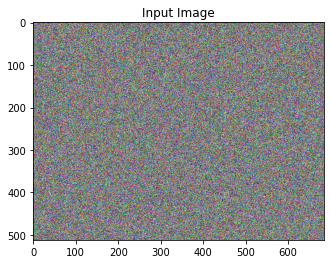

In [ ]:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
# This type of optimizer was prefered by the author of the paper
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [ ]:
# This will run the neural style transfer
# It will create image that goes above 1 or below 0, however it will be normalized
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction to have the tensors between 0 and 1
    input_img.data.clamp_(0, 1)

    return input_img

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=3000)



Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


run [50]:
Style Loss : 59.198856 Content Loss: 26.626625

run [100]:
Style Loss : 19.807259 Content Loss: 24.681280

run [150]:
Style Loss : 11.245728 Content Loss: 21.938354

run [200]:
Style Loss : 7.921463 Content Loss: 19.718424

run [250]:
Style Loss : 5.969738 Content Loss: 17.980047

run [300]:
Style Loss : 4.733263 Content Loss: 16.621628

run [350]:
Style Loss : 3.804845 Content Loss: 15.520692

run [400]:
Style Loss : 3.145643 Content Loss: 14.714416

run [450]:
Style Loss : 2.568115 Content Loss: 14.082948

run [500]:
Style Loss : 2.126437 Content Loss: 13.545202

run [550]:
Style Loss : 1.826555 Content Loss: 13.130050

run [600]:
Style Loss : 1.616668 Content Loss: 12.774175

run [650]:
Style Loss : 1.344389 Content Loss: 12.549003

run [700]:
Style Loss : 1.261946 Content Loss: 12.289128

run [750]:
Style Loss : 1.054262 Content Loss: 12.088500

run [800]:
Style Loss : 0.995892 Content Loss: 11.884895

run [850]:
Style Loss : 0.813684 Content Loss: 11.728998

run [900]:
S

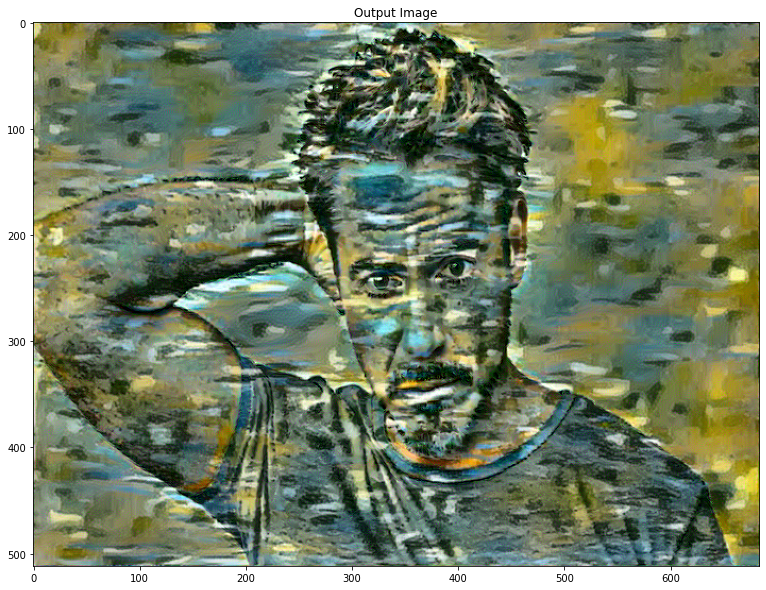

In [ ]:
plt.figure(figsize=(14,10))
imshow(output, title='Output Image')


# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()